Program written by: Ningyou Li, 20307142; This program read in prostate image and resample the image into proper dimension. Then a smoothing filter is applied to the image to reduce noise present in the image and histogram equalization is used to increase the contrast of the image. The processed image is then segmented and  quantitative measures are extract from the segmented image to calculate the prostate volume.

In [377]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
%config Completer.use_jedi = False

# Part 1

### a. Read Image

In [2]:
# SimpleITK read 'PCC-0312_LAL_GS7.tif'
img = sitk.ReadImage('PCC-0312_LAL_GS7.tif')

def image_Info(image):
    """
    :param image: the input image read by SimpleITK
    :return: None
    This function prints the properties of the image. Properties include: size, spacing, origin, direction, pixel type
    """
    print('Size:', image.GetSize()) #size
    print('Space:', image.GetSpacing()) #space
    print('Origin:', image.GetOrigin()) #origin
    print('Direction:', image.GetDirection()) #direction
    print('Pixel Type:', image.GetPixelIDTypeAsString()) #pixel type
    
image_Info(img)

Size: (512, 10048)
Space: (0.35277777777777775, 0.35277777777777775)
Origin: (0.0, 0.0)
Direction: (1.0, 0.0, 0.0, 1.0)
Pixel Type: 8-bit unsigned integer


In [4]:
# Set external viewer to 3D slicer and Open with external viewer
image_viewer = sitk.ImageViewer()
image_viewer.SetApplication('C:/Users/Linda/AppData/Local/NA-MIC/Slicer 4.11.20210226/Slicer.exe')
image_viewer.Execute(img)

### Visulize the image in 3D Slicer
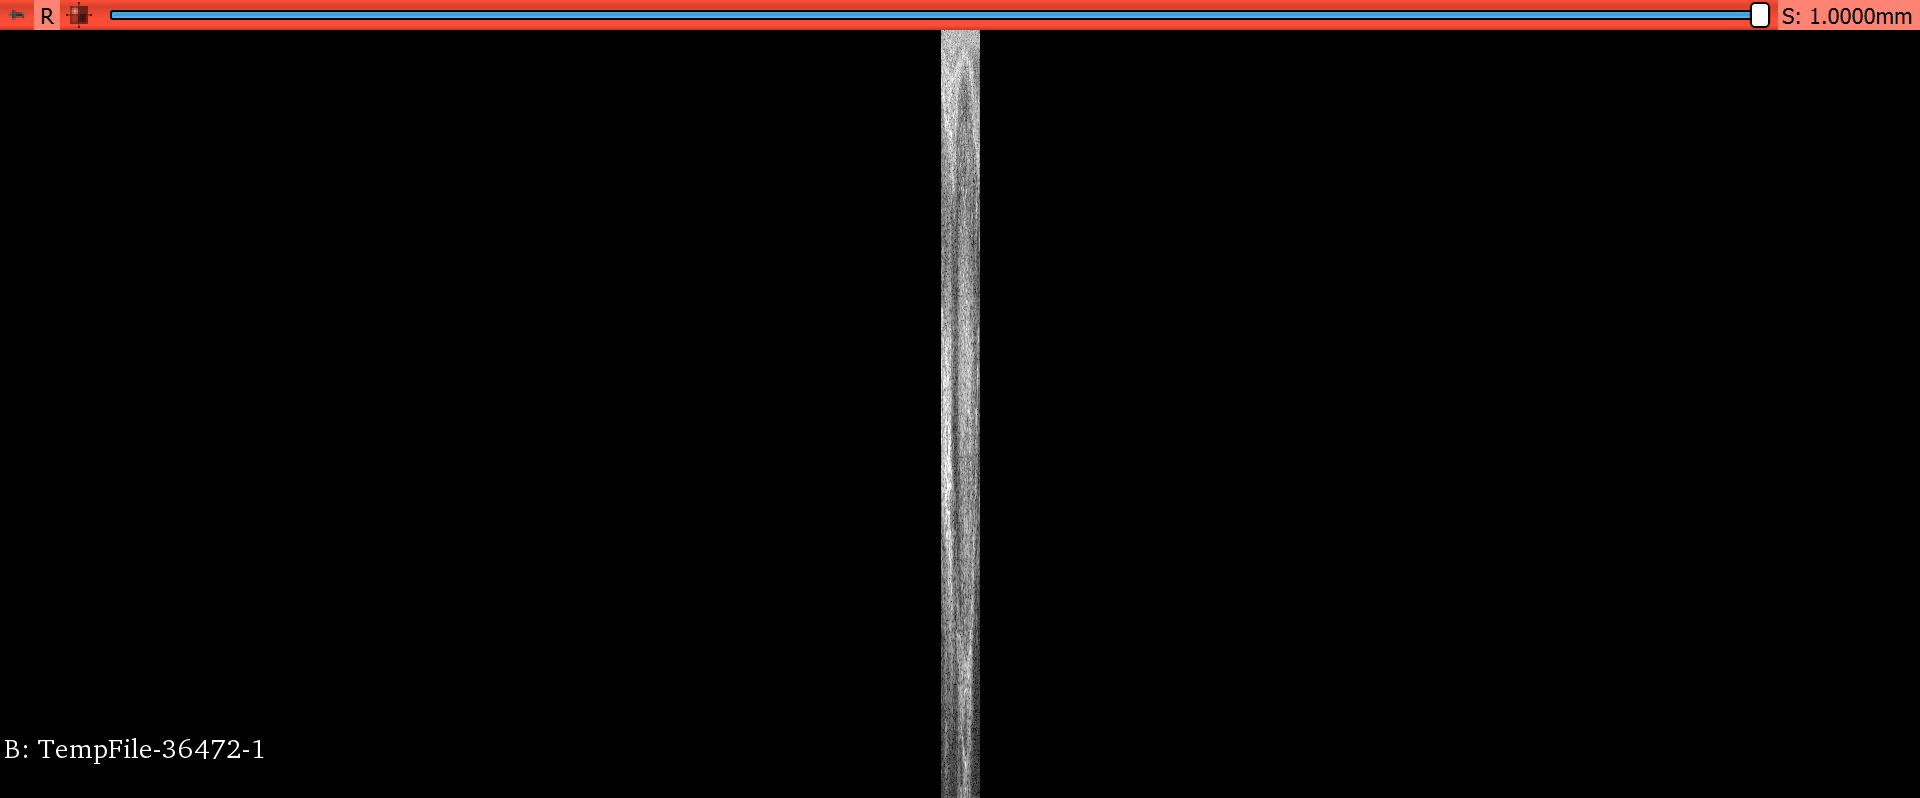

### b. Read .csv

In [6]:
# Read meta_data.csv using Pandas
data = pd.read_csv('meta_data.csv')
print(data, '\n')
print(data['axial (mm)'], '\n')
print(data['lateral (mm)'], '\n')

          data_name  axial (mm)  lateral (mm)  grade     organ    modality
0  PCC-0312_LAL_GS7          28         46.08      7  prostate  ultrasound 

0    28
Name: axial (mm), dtype: int64 

0    46.08
Name: lateral (mm), dtype: float64 



### c. Update New Spacing and Saved As .NNRD

In [19]:
# Calculate new spacing
vertical_spacing = data['axial (mm)']/img.GetSize()[1]
horizontal_spacing = data['lateral (mm)']/img.GetSize()[0]
new_spacing = (0.09, 0.002787)
print(horizontal_spacing)
print(vertical_spacing)
print(new_spacing)
# Calculate lateral to axial ratio
ratio = (data['lateral (mm)']/data['axial (mm)'])
print('lateral to axial ratio is:', ratio)
print('\nThe lateral extent to axial extent ratio is greater than 1, meaning that the width of the image is greater than the length of the image.')

0    0.09
Name: lateral (mm), dtype: float64
0    0.002787
Name: axial (mm), dtype: float64
(0.09, 0.002787)
lateral to axial ratio is: 0    1.645714
dtype: float64

The lateral extent to axial extent ratio is greater than 1, meaning that the width of the image is greater than the length of the image.


In [23]:
def data_resample(image, new_spacing):
    np.array(list(new_spacing))
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetTransform(sitk.Transform())
    # set direction
    resample.SetOutputDirection(image.GetDirection())
    # set origin
    resample.SetOutputOrigin(image.GetOrigin())
    # set new spacing
    resample.SetOutputSpacing(new_spacing)
    # set size
    resample.SetSize(image.GetSize())
    # set pixel type
    resample.SetDefaultPixelValue(img.GetPixelIDValue())
    newimage = resample.Execute(image)
    return newimage

# apply the function to resample the intra-operative image with spacing
resample_img = data_resample(img, new_spacing)
image_Info(resample_img)

Size: (512, 10048)
Space: (0.09, 0.002787)
Origin: (0.0, 0.0)
Direction: (1.0, 0.0, 0.0, 1.0)
Pixel Type: 8-bit unsigned integer


In [26]:
# save the resampled image as 'prostate_ultrasound.nrrd'
writer = sitk.ImageFileWriter()
writer.SetFileName('prostate_ultrasound.nrrd')
writer.Execute(resample_img)

### d. prostate_ultrasound.nrrd in 3D Slicer

In [27]:
# Open 'prostate_ultrasound.nrrd' in 3D slicer
prostate_img = sitk.ReadImage('prostate_ultrasound.nrrd')
image_viewer.SetFileExtension('.nrrd')
image_viewer.Execute(prostate_img)

In [28]:
image_Info(prostate_img)

Size: (512, 10048)
Space: (0.09, 0.002787)
Origin: (0.0, 0.0)
Direction: (0.9999999999999999, 0.0, 0.0, 1.0)
Pixel Type: 8-bit unsigned integer


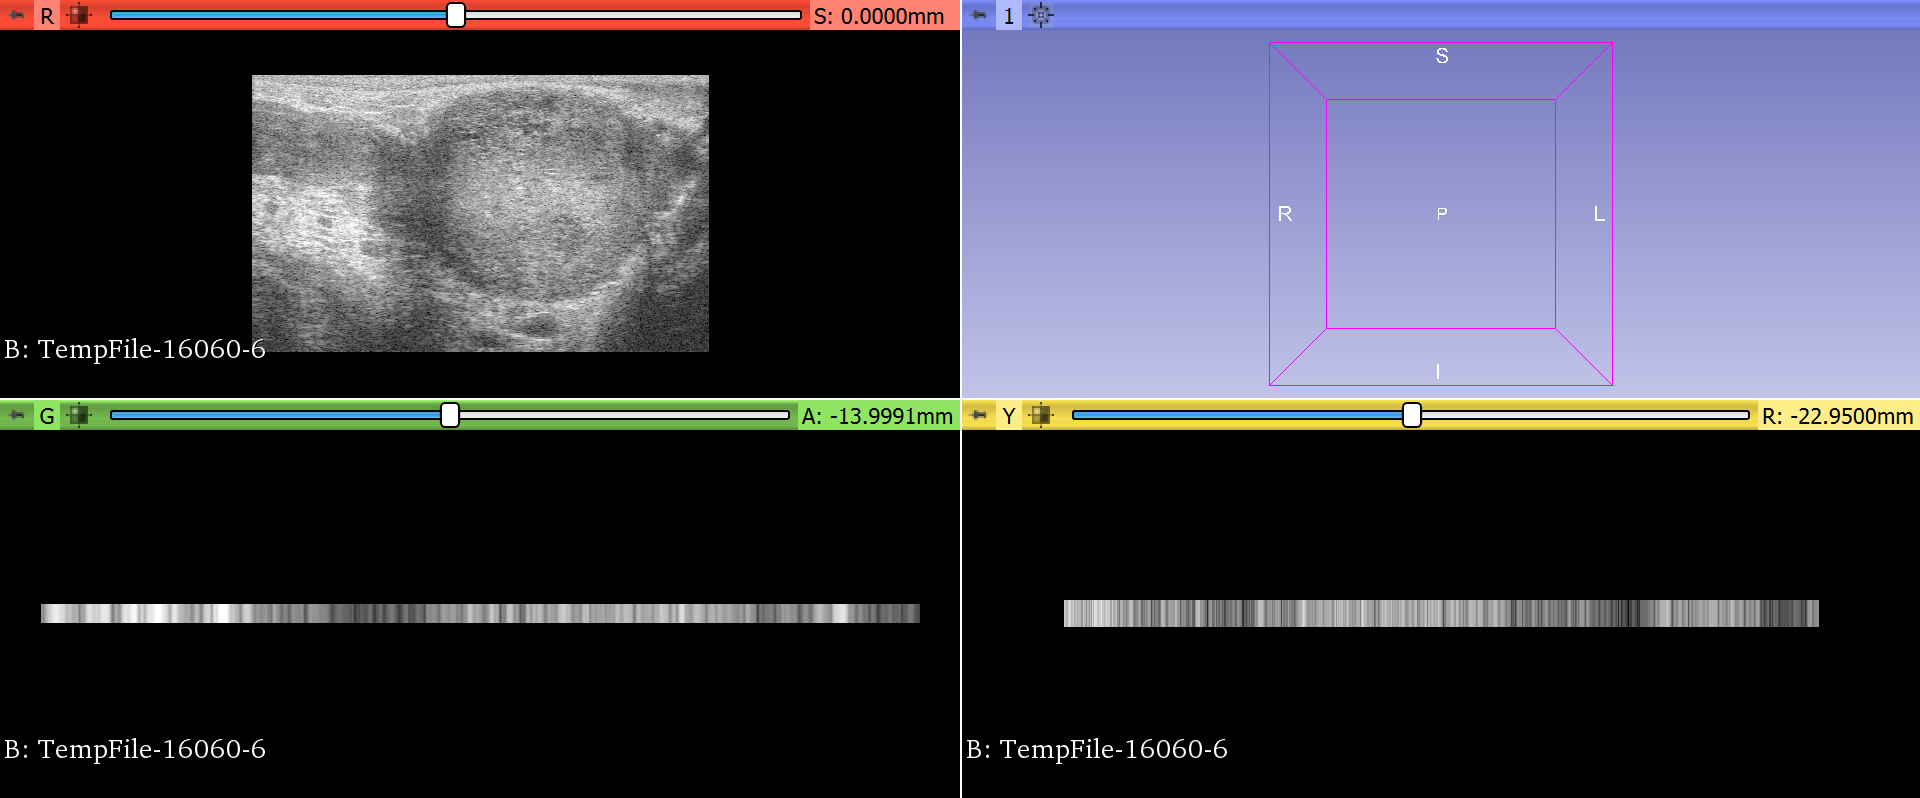

The resampled image has its width greater than its length which looks more like a prostate organ.

# Part 2



### a. Apply Median Filter

source: https://simpleitk.org/doxygen/v2_0/html/sitkAdaptiveHistogramEqualizationImageFilter_8h.html

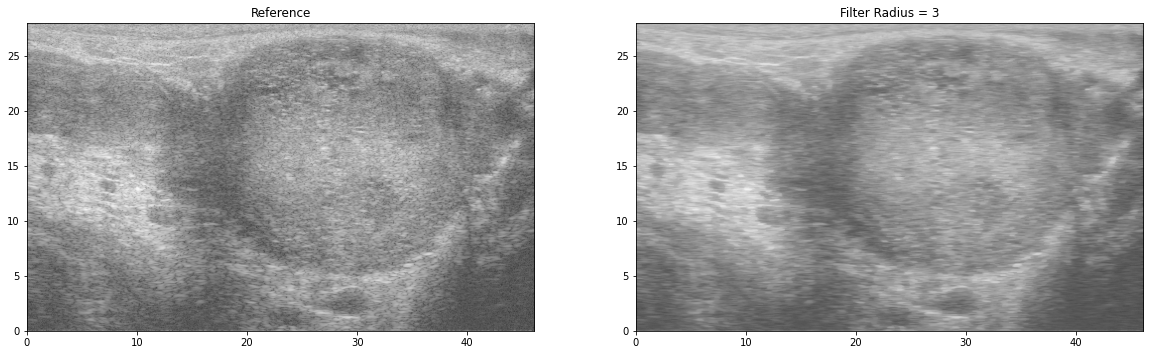

In [95]:
# Median smoothing, kernal radius = 3
median_filter = sitk.MedianImageFilter()
median_filter.SetRadius(3)
smoothed_img1 = median_filter.Execute(prostate_img)

# Show reference image and filtered images
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.gray()
plt.imshow(sitk.GetArrayFromImage(prostate_img),extent = [0, 46.08, 0, 28], vmin=0, vmax=255)
plt.title('Reference')
#plt.show()
plt.subplot(122)
#plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(smoothed_img1), extent = [0, 46.08, 0, 28], vmin=0, vmax=255) # vmax should be tunned based on the nature of the filtered image
plt.title('Filter Radius = 3')
plt.show()
#image_viewer.Execute(smoothed_img)

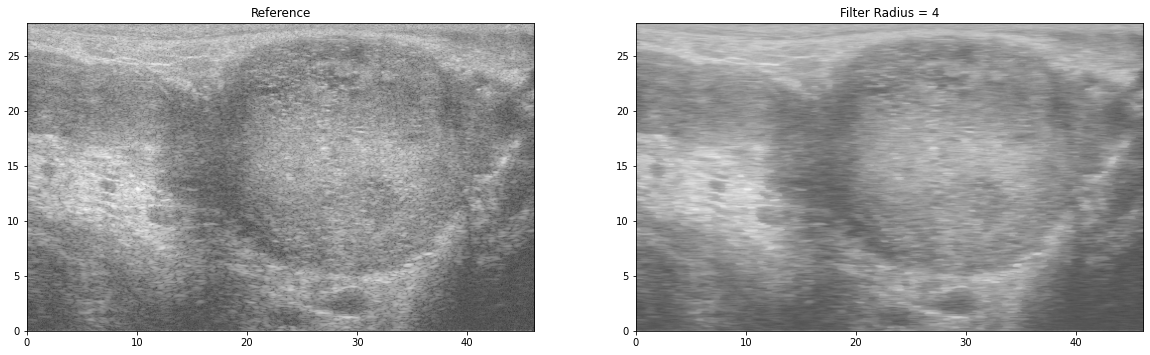

In [96]:
# Median smoothing, kernal radius = 4
median_filter = sitk.MedianImageFilter()
median_filter.SetRadius(4)
smoothed_img2 = median_filter.Execute(prostate_img)

# Show reference image and filtered images
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.gray()
plt.imshow(sitk.GetArrayFromImage(prostate_img),extent = [0, 46.08, 0, 28], vmin=0, vmax=255)
plt.title('Reference')
#plt.show()
plt.subplot(122)
#plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(smoothed_img2), extent = [0, 46.08, 0, 28], vmin=0, vmax=255) # vmax should be tunned based on the nature of the filtered image
plt.title('Filter Radius = 4')
plt.show()

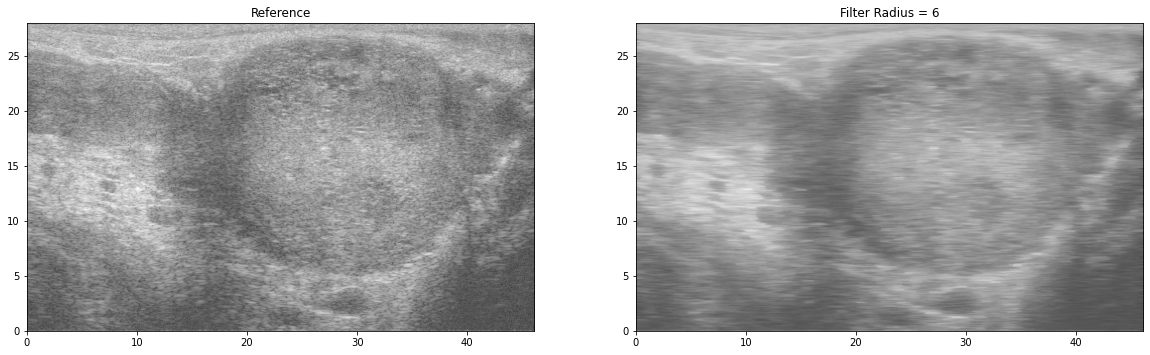

In [97]:
# Median smoothing, kernal radius = 6
median_filter = sitk.MedianImageFilter()
median_filter.SetRadius(6)
smoothed_img3 = median_filter.Execute(prostate_img)

# Show reference image and filtered images
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.gray()
plt.imshow(sitk.GetArrayFromImage(prostate_img),extent = [0, 46.08, 0, 28], vmin=0, vmax=255)
plt.title('Reference')
#plt.show()
plt.subplot(122)
#plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(smoothed_img3), extent = [0, 46.08, 0, 28], vmin=0, vmax=255) # vmax should be tunned based on the nature of the filtered image
plt.title('Filter Radius = 6')
plt.show()

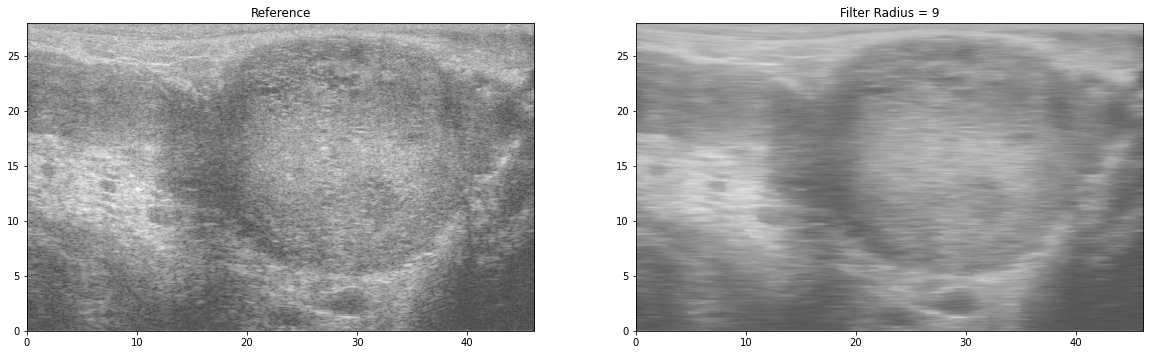

In [413]:
# Median smoothing, kernal radius = 9
median_filter = sitk.MedianImageFilter()
median_filter.SetRadius(9)
smoothed_img4 = median_filter.Execute(prostate_img)

# Show reference image and filtered images
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.gray()
plt.imshow(sitk.GetArrayFromImage(prostate_img),extent = [0, 46.08, 0, 28], vmin=0, vmax=255)
plt.title('Reference')
#plt.show()
plt.subplot(122)
#plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(smoothed_img4), extent = [0, 46.08, 0, 28], vmin=0, vmax=255) # vmax should be tunned based on the nature of the filtered image
plt.title('Filter Radius = 9')
plt.show()

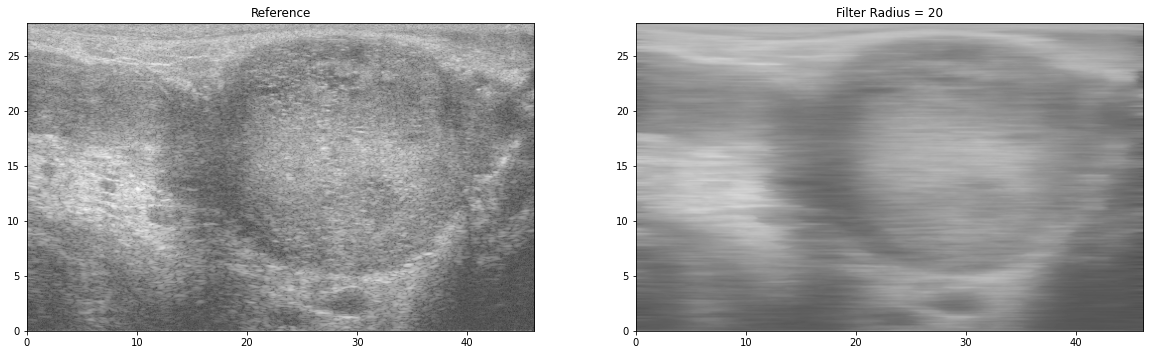

In [284]:
# Median smoothing, kernal radius = 20
median_filter = sitk.MedianImageFilter()
median_filter.SetRadius(20)
smoothed_img5 = median_filter.Execute(prostate_img)

# Show reference image and filtered images
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.gray()
plt.imshow(sitk.GetArrayFromImage(prostate_img),extent = [0, 46.08, 0, 28], vmin=0, vmax=255)
plt.title('Reference')
#plt.show()
plt.subplot(122)
#plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(smoothed_img5), extent = [0, 46.08, 0, 28], vmin=0, vmax=255) # vmax should be tunned based on the nature of the filtered image
plt.title('Filter Radius = 20')
plt.show()

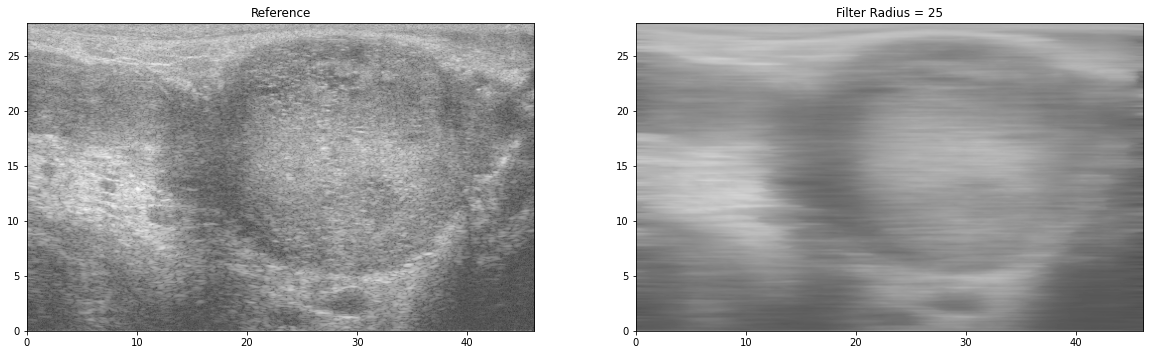

In [107]:
# Median smoothing, kernal radius = 25
median_filter = sitk.MedianImageFilter()
median_filter.SetRadius(25)
smoothed_img6 = median_filter.Execute(prostate_img)

# Show reference image and filtered images
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.gray()
plt.imshow(sitk.GetArrayFromImage(prostate_img),extent = [0, 46.08, 0, 28], vmin=0, vmax=255)
plt.title('Reference')
#plt.show()
plt.subplot(122)
#plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(smoothed_img6), extent = [0, 46.08, 0, 28], vmin=0, vmax=255) # vmax should be tunned based on the nature of the filtered image
plt.title('Filter Radius = 25')
plt.show()

### b. Plot Histograms and Apply Histogram Equalization on smoothed image with Filter Radius = 20

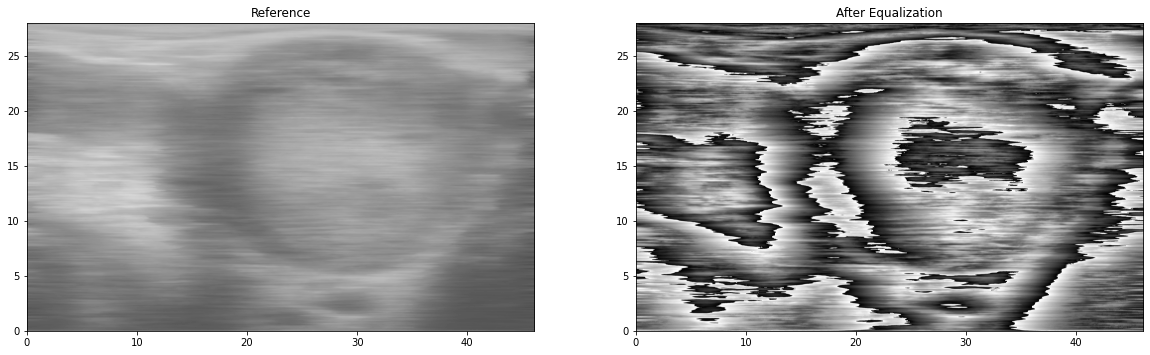

In [428]:
hist_equal_filter = sitk.AdaptiveHistogramEqualizationImageFilter()
hist_equal_filter.SetAlpha(0.1)
hist_equal_filter.SetBeta(5.5)
hist_equal_filter.SetRadius(40)
equalied_img5 = hist_equal_filter.Execute(smoothed_img5)

# Show reference image and filtered images
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.gray()
plt.imshow(sitk.GetArrayFromImage(smoothed_img5),extent = [0, 46.08, 0, 28], vmin=0, vmax=255)
plt.title('Reference')
#plt.show()
plt.subplot(122)
#plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(equalied_img5), extent = [0, 46.08, 0, 28], vmin=0, vmax=255) # vmax should be tunned based on the nature of the filtered image
plt.title('After Equalization')
plt.show()

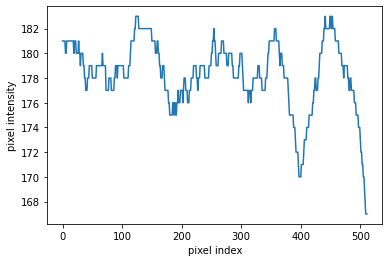

In [303]:
# plot profile of pixel intensities to visulize the effect of equalization
img_array = sitk.GetArrayFromImage(smoothed_img5)
image_line = img_array[18,:]
num_pixel_x = img.GetSize()[0]
pixel_size_x = img.GetSpacing()[0]
x = np.arange(num_pixel_x)*pixel_size_x
plt.plot(image_line)
plt.xlabel('pixel index')
plt.ylabel('pixel intensity')
plt.show()

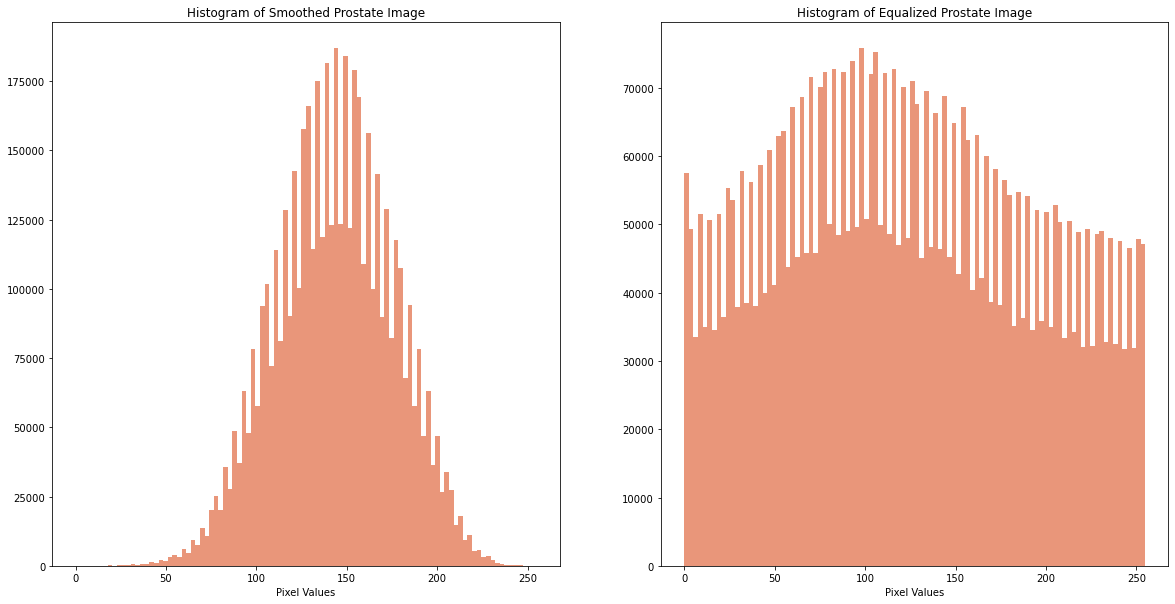

In [449]:
# Plot histogram of the equalised image
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.hist(sitk.GetArrayFromImage(img).flatten(), 100, color = 'darksalmon')
plt.title('Histogram of Smoothed Prostate Image')
plt.xlabel('Pixel Values')
plt.subplot(122)
plt.hist(sitk.GetArrayFromImage(equalied_img5).flatten(), 100, color = 'darksalmon')
plt.title('Histogram of Equalized Prostate Image')
plt.xlabel('Pixel Values')
plt.show()

The boarder of the equalized image is clearer and the contrast is higher compared to the original image. The histogram of the equalized image is wider in range than the original image and the bins of the histgram is more even.

# Part 3

### a. Region Growing

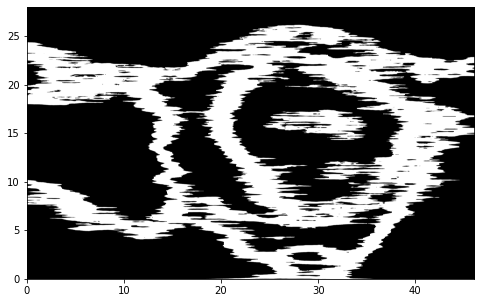

In [359]:
# Use region growing to segment the prostate
seed_pts = [(425,4463,4),(329,4400,4)]
#F4:(425,4463,4);F3:(236,4837,4); F2:(329,4400,4);F1:(327,6519,4)
growing_filter = sitk.ConfidenceConnectedImageFilter()
# set seed
growing_filter.SetSeedList(seed_pts)
# set range of pixel intensity
growing_filter.SetMultiplier(1)
growing_filter.SetNumberOfIterations(2)
con_growed_img1 = growing_filter.Execute(equalied_img5)

plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(con_growed_img1),extent = [0, 46.08, 0, 28])

In [345]:
image_viewer.Execute(con_growed_img1)

#### Range of Intensities of Equalized Image from Part 2
Range of Pixel intensity inside prostate: (18, 254); 
Range of Pixel intensity outside prostate: (33, 258)

### b. Locating 4 Fiducials

In [ ]:
image_viewer.Execute(equalied_img5)

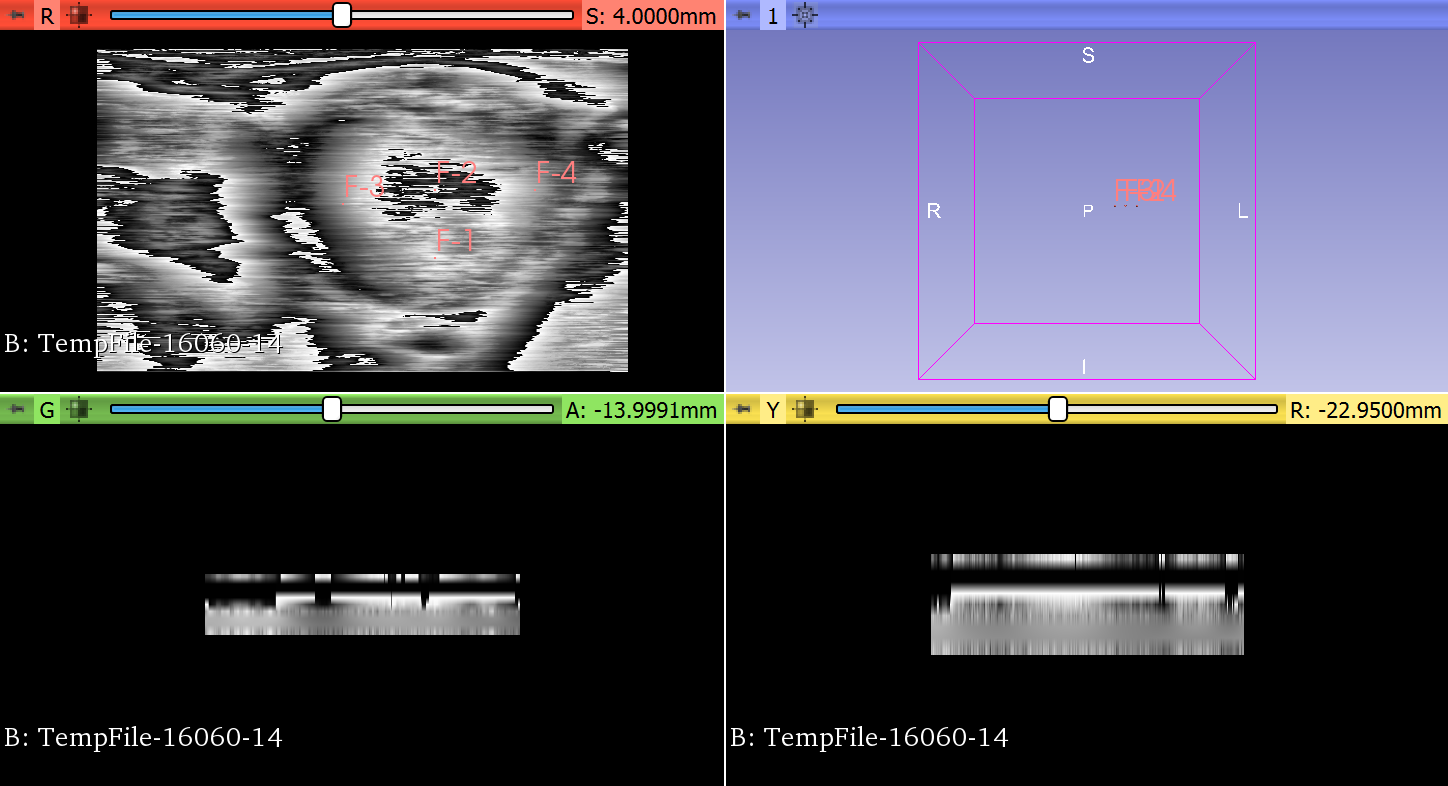

Fiducials 1 at (29.2, 18.3, 4); 
Fiducials 2 at (29.4, 18.3, 4); 
Fiducials 3 at (21.6, 13.5, 4); 
Fiducials 4 at (37.9, 12.3, 4); 

### c. Apply Region Growing in Slicer

source: https://www.orfeo-toolbox.org/SoftwareGuide/SoftwareGuidech16.html#x45-23900016.1

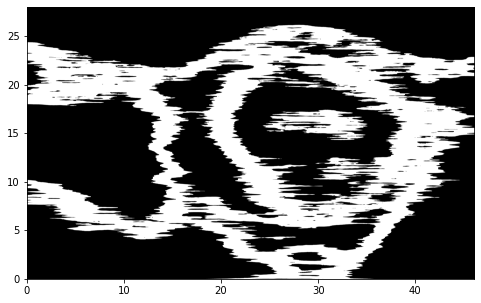

In [424]:
# Use ConfidenceConnectedImageFilter to grow region

seed_pts = [(425,4463,4),(329,4400,4)] 
# combo tried: F1; F1,F2; F1,F2,F4; F4, F1.
growing_filter = sitk.ConfidenceConnectedImageFilter()
# set seed
growing_filter.SetSeedList(seed_pts)
# set range of pixel intensity
growing_filter.SetMultiplier(1.5) 
# tried: 1, 1.5, 2, 5, 0.7, 0.5
growing_filter.SetNumberOfIterations(2)

growed_img = growing_filter.Execute(equalied_img5)

plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(growed_img),extent = [0, 46.08, 0, 28])

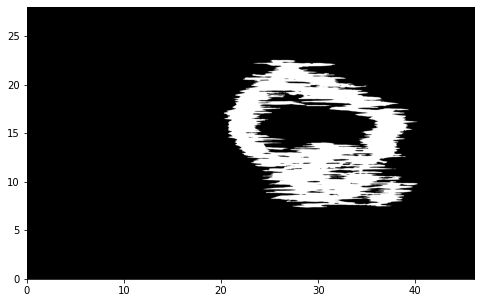

In [382]:
# Use ConnectedThresholdImageFilter() to grow region
ConnectedThresholdImageFilter = sitk.ConnectedThresholdImageFilter()
ConnectedThresholdImageFilter.SetLower(140)
# lower threshold tried: 0, 18, 30, 80, 90, 140
ConnectedThresholdImageFilter.SetUpper(254)
ConnectedThresholdImageFilter.SetSeedList([(425,4463,4),(329,4400,4)]) 
# #F4:(425,4463,4);F3:(236,4837,4); F2:(329,4400,4);F1:(327,6519,4)

threshold_img = ConnectedThresholdImageFilter.Execute(equalied_img5)

plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(threshold_img),extent = [0, 46.08, 0, 28])

### d. Segmentation Mask with Overlay Function

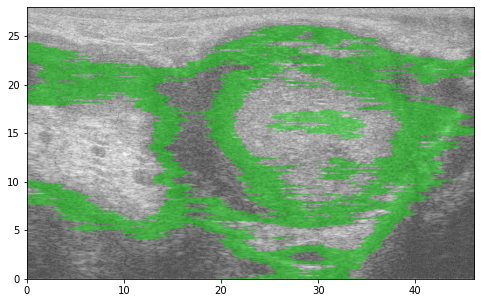

In [434]:
# Overlay ConfidenceConnected mask on image frame
overlay_confident = sitk.LabelOverlay(img, growed_img)
plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(overlay_confident), extent = [0, 46.08, 0, 28])

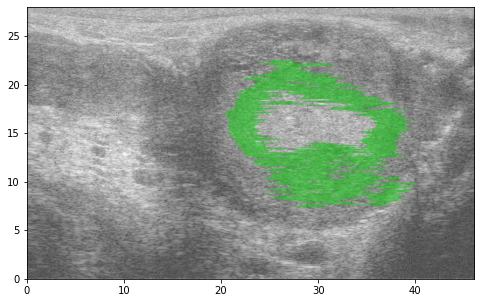

In [436]:
# Overlay ConnectedThreshold mask on image frame
overlay_threshold = sitk.LabelOverlay(img, threshold_img)
plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(overlay_confident), extent = [0, 46.08, 0, 28])

# Part 4

### a. Delineate the Prostate and Calculate the Area of the Prostate

In [460]:
img_array = sitk.GetArrayFromImage(threshold_img)
# Get the number of pixels in the prostate
# stats = sitk.LabelShapeStatisticsImageFilter()
# stats.Execute(sitk.ConnectedComponent(threshold_img))

# # Look at the distribution of sizes of connected components (bacteria).
# label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 1]

pixels = len(np.column_stack(np.where(img_array > 0)))
# Calculate the area of the prostate
prostate_area = (img.GetSpacing()[0]*img.GetSpacing()[1])*pixels
print('Number of pixels in prostate:', pixels)
print('prostate size is:', area, 'mm^2')
image_area = 46.08 * 28
print('Total image size is:', image_area, 'mm^2')

Number of pixels in prostate: 531789
prostate size is: 133.38863487 mm^2
Total image size is: 1290.24 mm^2


### b. Volume of Prostate

In [430]:
volume = (np.pi/6)*prostate_area*15*0.001
print('Volume of Prostate is:', volume, 'cubic centimeter')

Volume of Prostate is: 1.0476318884499083 cubic centimeter


### c. Mean and Standard Deviation of Pixel Intensities

In [464]:
# get pixel intensities inside prostate as an array 
prostate = img * threshold_img
prostate_array = sitk.GetArrayFromImage(prostate)
prostate_array = prostate_array[prostate_array != 0]
# Find the mean of them
pixel_mean = np.mean(prostate_array)
# Find Standard Deviation of them
pixel_sd = np.std(prostate_array)
print('Mean of the pixel intensity inside prostate is:', pixel_mean)
print('Standard Deviation of the pixel intensity inside prostate is:', pixel_sd)

531789
531789
10048
Mean of the pixel intensity inside prostate is: 154.15356090479494
Standard Deviation of the pixel intensity inside prostate is: 18.700490141104904


### d. Plot Intensity Distribution inside Prostate

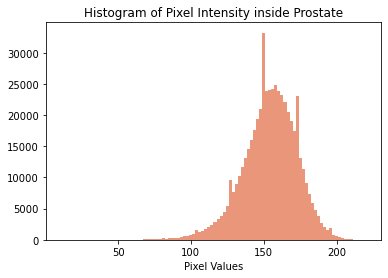

In [465]:
# Plot Histogram for region inside prostate
plt.hist(prostate_array.flatten(), 100, color = 'darksalmon')
plt.title('Histogram of Pixel Intensity inside Prostate')
plt.xlabel('Pixel Values')
plt.show()